In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(256),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:16<00:00, 10103936.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

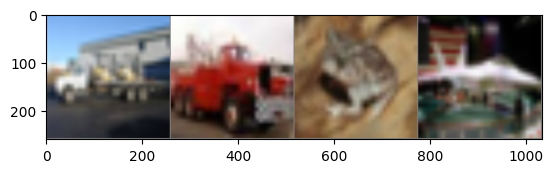

truck truck frog  plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

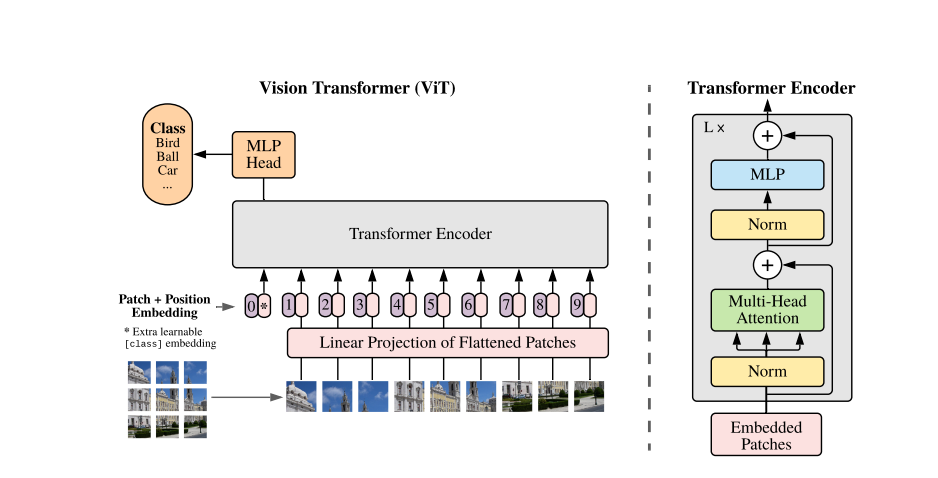

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Projection_Layer(nn.Module):
    def __init__(self, num_patches,patch_size,in_channels, embed_size):
        super(Projection_Layer, self).__init__()


        self.num_patches = num_patches
        self.layer_norm_1 = nn.LayerNorm(patch_size*patch_size*in_channels)
        self.embed_layer = nn.Linear(patch_size*patch_size*in_channels,embed_size)
        self.layer_norm_2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        b,_,_,_ = x.shape
        x = x.view(b,self.num_patches,-1)
        x = self.layer_norm_1(x)
        x = self.embed_layer(x)
        x = self.layer_norm_2(x)

        return x

class Attention(nn.Module):
    def __init__(self,num_heads, embed_size):
        super(Attention, self).__init__()
        
        eff_embed_size = embed_size//num_heads
        self.num_heads = num_heads
        self.Q_matrix = nn.Linear(eff_embed_size,eff_embed_size)
        self.K_matrix = nn.Linear(eff_embed_size,eff_embed_size)
        self.V_matrix = nn.Linear(eff_embed_size,eff_embed_size)
        self.temperature = eff_embed_size**0.5

    def forward(self, x):
        bs,n_1,embed_dim = x.shape
        x = x.view(bs,self.num_heads,n_1,embed_dim//self.num_heads)  ## B, head, 256, 192//head
        q = self.Q_matrix(x)
        k = self.K_matrix(x)
        v = self.V_matrix(x)

        attention = nn.Softmax(dim=-1)(torch.matmul(q,k.transpose(-1,-2)))/self.temperature
        x = torch.matmul(attention,v)
        x = x.view(bs,n_1,embed_dim)
        return x
    
class Transformer_Block(nn.Module):
    def __init__(self, num_heads,embed_size,hidden_dim,dropout):
        super(Transformer_Block, self).__init__()
        
        self.norm = nn.LayerNorm(embed_size)
        self.attn = Attention(num_heads, embed_size)
        self.MLP = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embed_size),
            nn.Dropout(dropout)
        )
    def forward(self,x):
        x = self.norm(x)
        x = self.attn(x) + x
        x = self.MLP(x) + x
        
        return x
        
class Vision_Transformer(nn.Module):
    def __init__(self, image_size=256,in_channels=3, patch_size = 16, embed_size=192,hidden_dim=512, num_heads = 8,num_layers=4,dropout=0.01):
        super(Vision_Transformer, self).__init__()

        self.num_patches = (image_size//patch_size)**2
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.projection_layer = Projection_Layer(self.num_patches,patch_size,in_channels, embed_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, self.embed_size))
        self.pos_emb = nn.Parameter(torch.randn(1, self.num_patches + 1, self.embed_size))

        self.layers = nn.Sequential(*[Transformer_Block(num_heads,embed_size,hidden_dim,dropout)
                                      for i in range(num_layers)])

        self.clf_head = nn.Linear(embed_size,10)

    def forward(self, x):
        bs,_,_,_ = x.shape
        x = self.projection_layer(x) ## B, 256, 192

        cls_token = torch.cat(bs*[self.cls_token], dim=0) ## broadcasting
        x = torch.concat([cls_token,x],dim=1)
        
        x = x + self.pos_emb

        for layer in self.layers:
            x = layer(x)

        x = self.clf_head(x[:,0,:])
        return x

In [18]:
net = Vision_Transformer().cuda()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=2e-4, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [19]:
from tqdm import tqdm
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].cuda(), data[1].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[1,  2000] loss: 2.410


KeyboardInterrupt: 